# Previsão de demanda energética

Previsão de 1 hora na frente utilizando apenas uma rede com janela de 24H.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sb
import statsmodels.api as sm


C:\Users\Pedro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Carregar dataset residencial

In [2]:
casas = {}
for i, filePath in enumerate(sorted(glob.glob('Corporativo/*.csv'))):
    casas[i] = pd.read_csv(filePath).filter(['date', 'activeEnergy', 'cepa', 'cepb', 'cepc'])
    #casas[i] = casas[i].dropna(axis = 'columns', how = 'all')
    casas[i]['date'] = pd.to_datetime(casas[i]['date'], yearfirst=True, dayfirst= True, errors = 'coerce')
    casas[i]['weekDay'] = casas[i]['date'].dt.weekday
    casas[i]['hours'] = casas[i]['date'].dt.hour
    casas[i]['EnergyNextHour'] = casas[i]['activeEnergy'].shift(-1)
    casas[i]['EnergyNext2Hours'] = casas[i]['activeEnergy'].shift(-2)
    casas[i].drop(casas[i].index[-3:], inplace = True)
    #casas[i].dropna(axis = 0, how = 'any', inplace = True)
    
    #casas[i] = casas[i][casas[i]['activeEnergy'] < 4*casas[i]['activeEnergy'].std()]

In [3]:
a = 7

In [4]:
print(pd.isnull(casas[a]).any())
#df.loc[df['column_name'] == some_value]

casas[a].head()

date                False
activeEnergy        False
cepa                False
cepb                False
cepc                False
weekDay             False
hours               False
EnergyNextHour      False
EnergyNext2Hours    False
dtype: bool


,date,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
0,2017-03-01 00:00:00,9736,2696,5273,1767,2,0,11733.0,9170.0
1,2017-03-01 01:00:00,11733,3608,6011,2114,2,1,9170.0,11795.0
2,2017-03-01 02:00:00,9170,2498,5094,1578,2,2,11795.0,9227.0
3,2017-03-01 03:00:00,11795,3525,6087,2183,2,3,9227.0,8965.0
4,2017-03-01 04:00:00,9227,2532,5151,1544,2,4,8965.0,9402.0


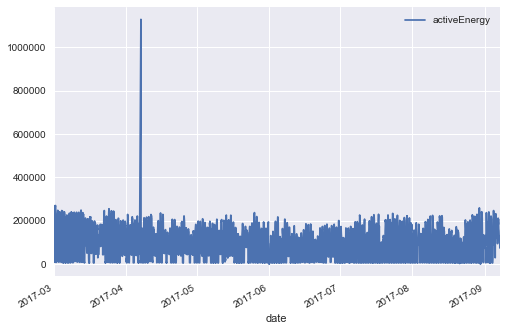

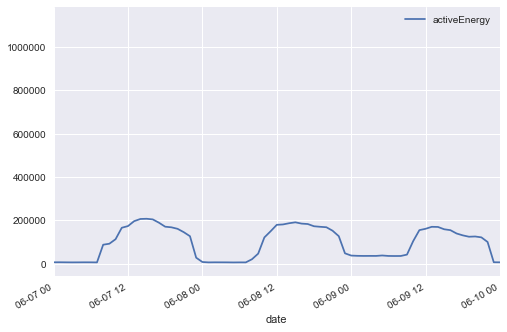

In [5]:
casas[a].plot(x = 'date', y = ['activeEnergy'])#, xlim = ['2017-03-01 00:00:00', ['2017-03-02 00:00:00']])
plt.show()
casas[a].plot(x = 'date', y = ['activeEnergy'], xlim = ['2017-06-07 00:00:00', ['2017-06-10 00:00:00']])
plt.show()

## Truncar os dados

In [6]:
train_set = casas[a][casas[a]['date'] < '2017-08-15 00:00:00']
test_set = casas[a][casas[a]['date'] > '2017-08-15 00:00:00']#.reset_index()

## Retirar tendência

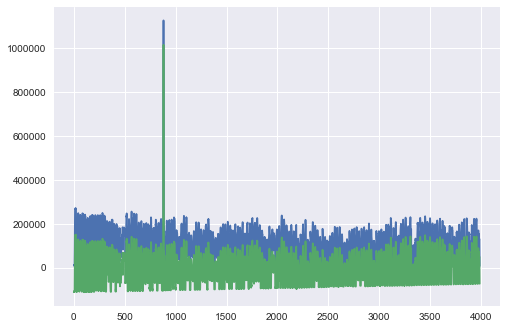

In [7]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
#print(train_set.index.shape, train_set['activeEnergy'].shape)
linearReg.fit(train_set.index[:, np.newaxis], train_set['activeEnergy'])
train_set_without_tendency = train_set['activeEnergy'] - linearReg.predict(train_set.index[:, np.newaxis])
plt.plot(train_set['activeEnergy'])
plt.plot(train_set_without_tendency)
plt.show()

In [8]:
F = train_set.set_index('date')
#print(F.index.freq)
s = sm.tsa.seasonal_decompose(F.activeEnergy, freq = 24)

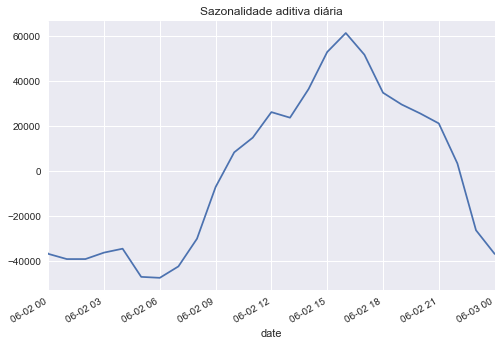

In [9]:
s.seasonal.plot(xlim = ['2017-06-02', '2017-06-03'])
plt.title('Sazonalidade aditiva diária')
plt.show()

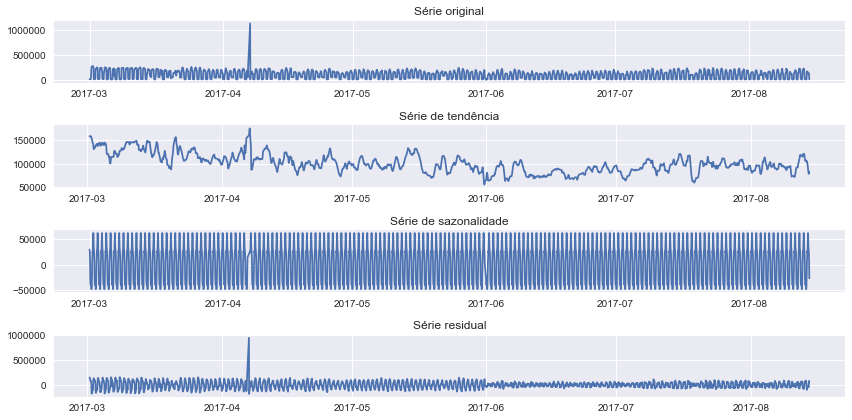

In [10]:
fig, axes = plt.subplots(4,1, figsize = (12, 6))
axes[0].plot(train_set.set_index('date')['activeEnergy'])
axes[0].set_title('Série original')
axes[1].plot(s.trend)
axes[1].set_title('Série de tendência')
axes[2].plot(s.seasonal)
axes[2].set_title('Série de sazonalidade')
axes[3].plot(s.resid)
axes[3].set_title('Série residual')
plt.tight_layout()
plt.show()

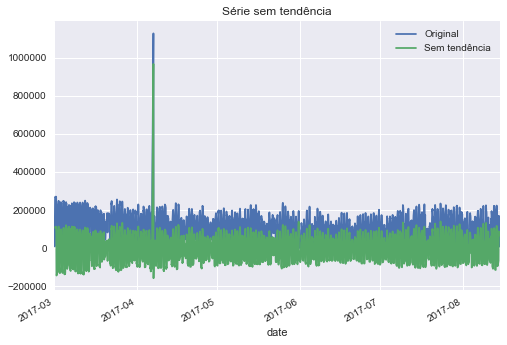

In [11]:
train_set_without_tendency = train_set.set_index('date')['activeEnergy'] - s.trend
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_tendency.plot()
plt.title('Série sem tendência')
plt.legend(['Original', 'Sem tendência'])
plt.show()

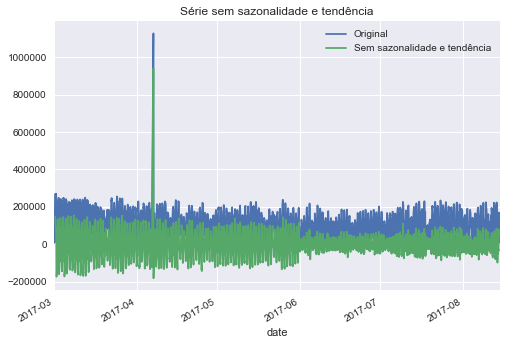

In [12]:
train_set_without_season = train_set_without_tendency - s.seasonal
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_season.plot()
plt.legend(['Original', 'Sem sazonalidade e tendência'])
plt.title('Série sem sazonalidade e tendência')
plt.show()


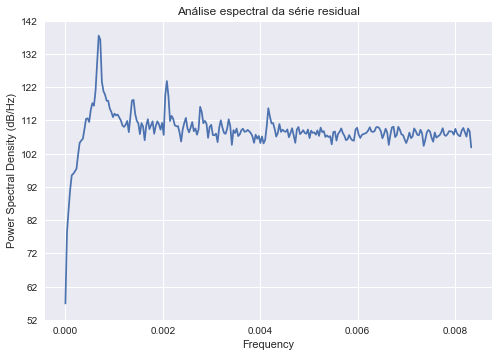

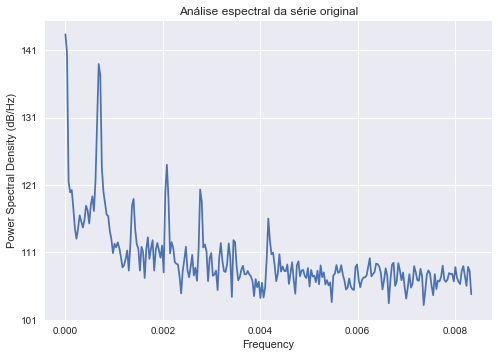

In [13]:
plt.psd(s.resid.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série residual')
plt.show()
plt.psd(F.activeEnergy.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série original')
plt.show()

In [14]:
train_set.set_index('date', inplace = True)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-03-01 12:00:00,264522,103033,81091,80398,2,12,269691.0,268806.0,148380.731135,-42582.543635,158723.812500
2017-03-01 13:00:00,269691,104390,83328,81973,2,13,268806.0,269172.0,141284.887762,-30251.012762,158657.125000
2017-03-01 14:00:00,268806,104084,82742,81980,2,14,269172.0,268889.0,117478.757993,-7269.382993,158596.625000
2017-03-01 15:00:00,269172,104314,83109,81749,2,15,268889.0,266366.0,102418.264142,8161.506691,158592.229167
2017-03-01 16:00:00,268889,104574,82828,81487,2,16,266366.0,270185.0,95484.629353,14706.578980,158697.791667


In [15]:
test_set.set_index('date', inplace = True)
test_set = test_set[:'2017-08-26']
print(test_set.index.freq)
test_set.tail()

None


,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
date,,,,,,,,
2017-08-26 19:00:00,213210,82948,66259,64003,5,19,197262.0,176474.0
2017-08-26 20:00:00,197262,77490,61216,58556,5,20,176474.0,89095.0
2017-08-26 21:00:00,176474,68821,56236,51417,5,21,89095.0,7201.0
2017-08-26 22:00:00,89095,34215,32323,22557,5,22,7201.0,6786.0
2017-08-26 23:00:00,7201,2387,3906,908,5,23,6786.0,6917.0


In [16]:
#test_set.set_index('date', inplace = True)
F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(F, freq = 24)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-08-15 13:00:00,126788,51361,42453,32974,1,13,123750.0,127227.0,-8045.765057,65043.660890,69790.104167
2017-08-15 14:00:00,123750,50479,41509,31762,1,14,127227.0,135893.0,-13774.848390,67724.806723,69800.041667
2017-08-15 15:00:00,127227,51992,42491,32744,1,15,135893.0,123202.0,-9623.969602,67029.344602,69821.625000
2017-08-15 16:00:00,135893,54055,46970,34868,1,16,123202.0,118356.0,-891.071875,66942.176042,69841.895833
2017-08-15 17:00:00,123202,47691,44351,31160,1,17,118356.0,120556.0,-9493.835133,62830.897633,69864.937500


## Pré processamento dos dados

In [17]:
matrix =  casas[a].as_matrix(columns = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 
                                        'hours', 'EnergyNextHour', 'EnergyNext2Hours']).T
print(matrix.shape)
correlationCoef = np.corrcoef(matrix[:,3:])

(8, 4550)


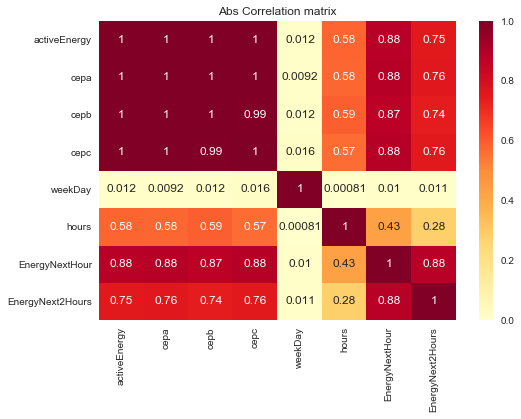

In [18]:
sb.heatmap(np.abs(correlationCoef),
           annot=True, cmap = 'YlOrRd', vmin = 0, vmax =  1,
          xticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'],
          yticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'])
plt.title('Abs Correlation matrix')
plt.show()

## Regressão com Multilayer Perceptron

In [19]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


In [20]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return np.array(dataX), np.array(dataY)

In [21]:
train_set.shape
#create_dataset(train_series, look_back = 6)

(3965, 11)

In [22]:
look_back  = 24

In [23]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values, look_back = look_back)
testx, testy = create_dataset(test_values, look_back = look_back)
print(y[:10], '\n',train_values[:30])
print(x.shape, y.shape)

[ 1.9730882   1.7727559   1.49038016  1.27298495  1.25827295  1.24142967
  1.27959248  1.14774354  0.78259974  0.26188714] 
 [ 2.20963319  2.10390982  1.74921425  1.52482287  1.4215163   1.2119802
  1.30456128  1.1135986   0.8925376   0.74774274  0.36377563 -2.39525273
 -2.58985676 -2.50168331 -2.41121873 -2.07442082 -1.57380833 -1.41241012
 -1.42680697 -1.33727022 -1.32797172  1.65255781  1.92190179  1.97783882
  1.9730882   1.7727559   1.49038016  1.27298495  1.25827295  1.24142967]
(3940, 24) (3940,)


In [24]:
from keras.regularizers import l2
model = Sequential()
model.add(Dense(24*3, input_dim = look_back, 
                activation = 'selu', 
                kernel_initializer = 'lecun_normal', 
                kernel_regularizer = l2(l=0.007)
               )
         )
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [25]:
history = model.fit(x, y, epochs = 200, validation_split = 0.2, batch_size = 41, verbose =  2)

Train on 3152 samples, validate on 788 samples
Epoch 1/200
0s - loss: 1.0055 - val_loss: 0.6035
Epoch 2/200
0s - loss: 0.6950 - val_loss: 0.5375
Epoch 3/200
0s - loss: 0.6184 - val_loss: 0.4908
Epoch 4/200
0s - loss: 0.5707 - val_loss: 0.4516
Epoch 5/200
0s - loss: 0.5359 - val_loss: 0.4499
Epoch 6/200
0s - loss: 0.5058 - val_loss: 0.4138
Epoch 7/200
0s - loss: 0.4786 - val_loss: 0.3878
Epoch 8/200
0s - loss: 0.4552 - val_loss: 0.3657
Epoch 9/200
0s - loss: 0.4328 - val_loss: 0.3483
Epoch 10/200
0s - loss: 0.4123 - val_loss: 0.3393
Epoch 11/200
0s - loss: 0.3963 - val_loss: 0.3331
Epoch 12/200
0s - loss: 0.3800 - val_loss: 0.3066
Epoch 13/200
0s - loss: 0.3642 - val_loss: 0.2918
Epoch 14/200
0s - loss: 0.3515 - val_loss: 0.2850
Epoch 15/200
0s - loss: 0.3344 - val_loss: 0.2788
Epoch 16/200
0s - loss: 0.3273 - val_loss: 0.2555
Epoch 17/200
0s - loss: 0.3154 - val_loss: 0.2459
Epoch 18/200
0s - loss: 0.3039 - val_loss: 0.2363
Epoch 19/200
0s - loss: 0.2947 - val_loss: 0.2260
Epoch 20/200

0s - loss: 0.1482 - val_loss: 0.0981
Epoch 164/200
0s - loss: 0.1527 - val_loss: 0.0906
Epoch 165/200
0s - loss: 0.1509 - val_loss: 0.0929
Epoch 166/200
0s - loss: 0.1532 - val_loss: 0.0942
Epoch 167/200
0s - loss: 0.1518 - val_loss: 0.0919
Epoch 168/200
0s - loss: 0.1526 - val_loss: 0.0909
Epoch 169/200
0s - loss: 0.1479 - val_loss: 0.0912
Epoch 170/200
0s - loss: 0.1498 - val_loss: 0.0881
Epoch 171/200
0s - loss: 0.1495 - val_loss: 0.0893
Epoch 172/200
0s - loss: 0.1488 - val_loss: 0.0904
Epoch 173/200
0s - loss: 0.1507 - val_loss: 0.0965
Epoch 174/200
0s - loss: 0.1477 - val_loss: 0.0898
Epoch 175/200
0s - loss: 0.1450 - val_loss: 0.0978
Epoch 176/200
0s - loss: 0.1503 - val_loss: 0.0937
Epoch 177/200
0s - loss: 0.1466 - val_loss: 0.0914
Epoch 178/200
0s - loss: 0.1470 - val_loss: 0.1022
Epoch 179/200
0s - loss: 0.1497 - val_loss: 0.0910
Epoch 180/200
0s - loss: 0.1500 - val_loss: 0.0913
Epoch 181/200
0s - loss: 0.1484 - val_loss: 0.0897
Epoch 182/200
0s - loss: 0.1478 - val_loss: 0

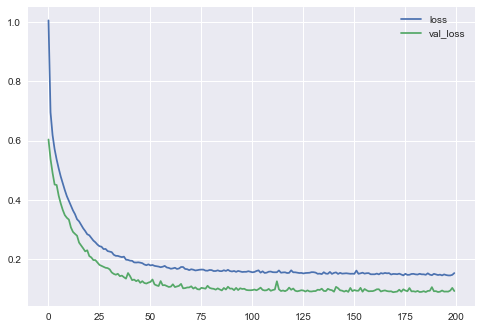

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
predictedTest = model.predict(testx)

ploting = predictedTest*test_std + test_mean 
ploting += test_set['SeasonalSeries'].values[23:-2, np.newaxis] +test_set['TrendSeries'].values[23:-2, np.newaxis]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting.shape)


21152.965950535596 -376.251799242418
(262,) (262,)
(237, 1) (237, 1)


In [28]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTest, testy))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting, test_set['activeEnergy'][23:-2].values))

Mean absolute error for residual series: 0.4779
Mean absolute error for complete series: 7928.4367


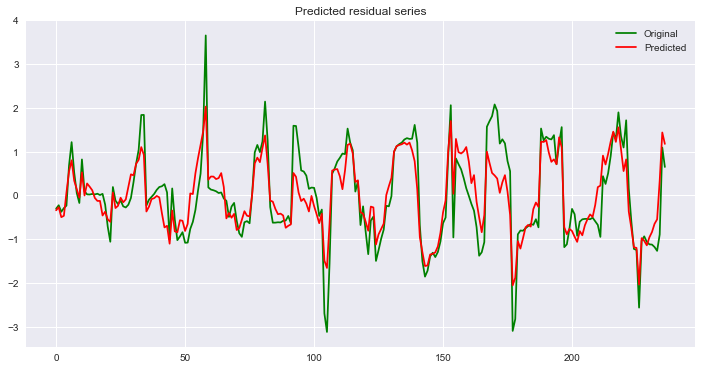

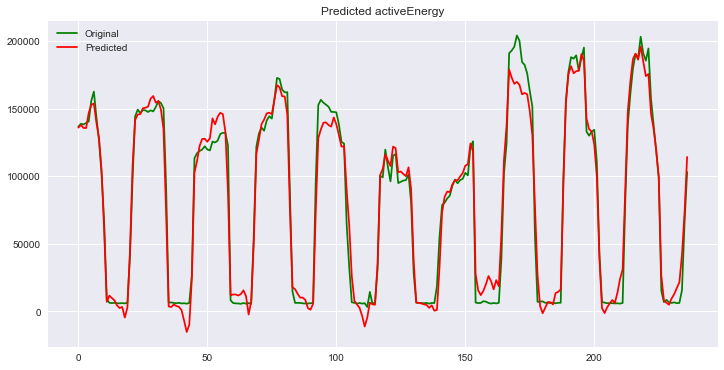

In [29]:
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(test_set['ResidualSeries'][23:-2].values, 'g')
plt.plot(predictedTest, 'r')
plt.legend(['Original', 'Predicted'])
plt.show()

plt.figure(figsize = (12,6))
plt.title('Predicted activeEnergy')
plt.plot(test_set['activeEnergy'][23:-2].values, 'g')
plt.plot(ploting, 'r')
plt.legend(['Original', 'Predicted'])
#plt.text('MSE %.3f'%)
plt.show()
